In [118]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt

%matplotlib inline

In [119]:
# Cleaning up Kevin's Data

import pandas as pd
import numpy as np

def fixing_time_str(df):
    time = np.zeros(len(df['TestTime']))

    for i in range(len(df['TestTime'])):
        if '-' not in df['TestTime'][i]:
            hr = float(df['TestTime'][i].split(':')[0]) * 3600
            mins = float(df['TestTime'][i].split(':')[1]) * 60
            sec = float(df['TestTime'][i].split(':')[2])
            time[i] = hr + mins + sec
        if '-' in df['TestTime'][i]:
            day = float(df['TestTime'][i].split('-')[0])*86400
            idx2 = df['TestTime'][i].split('-')[1]
            hr = float(idx2.split(':')[0]) * 3600
            mins = float(idx2.split(':')[1]) * 60
            sec = float(idx2.split(':')[2])
            time[i] = day + hr + mins+ sec
    
    df['Time'] = pd.Series(data = time)
            
    return df

In [120]:
import pandas as pd
import numpy as np

def pulse_separations(df):
    d = {}
    current = np.array(df['Current'])
    workingcurrent = np.argwhere(current != 0)
    startidx = int(workingcurrent[0])
    cycle = 1

    for i in range(len(workingcurrent)-1):
        if workingcurrent[i + 1] - workingcurrent[i] != 1:
            endidx = int(workingcurrent[i +1] - 1)
            d[cycle] = df[startidx:endidx]
            d[cycle] = d[cycle].reset_index(drop = True)

            startidx = int(workingcurrent[i +1])
            cycle = cycle + 1
    
    return d
                       

In [121]:
import pandas as pd

def transient_pulses(df):
    
    d = pulse_separations(df)
    
    d_trans = {}
    dkeys = d.keys()

    for key in dkeys:
        mask = d[key]['Current'] != 0
        d_trans[key] = d[key][mask]
        d_trans[key] = d_trans[key].reset_index(drop = True)

        d_trans[key]['sqrt_time_diff'] = np.sqrt(d_trans[key]['Time'] - d_trans[key]['Time'][0])
    
    return d_trans

In [140]:
def find_linear_fit(x, y, window):
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import mean_squared_error

    n = window//2
    coefs = []
    mses = []
    intcs = []
    starts = []
    ends = []

    for i in range(n,int(len(x)-n)):
        x_range = np.array(x[(i-n):(i+n)]).reshape(-1, 1)
        y_range = np.array(y[(i-n):(i+n)]).reshape(-1, 1)

        lin_model = LinearRegression()
        lin_model.fit(x_range, y_range)
        y_pred = lin_model.predict(y_range)
        coef = lin_model.coef_
        intc = lin_model.intercept_
        mse = mean_squared_error(y_range, y_pred)
        startidx = int(i - n)
        endidx = int(i + n)

        starts.append(startidx)
        ends.append(endidx)
        coefs.append(coef.flatten()[0])
        intcs.append(intc.flatten()[0])
        mses.append(mse)

        data = pd.DataFrame()
        data['start_idx'] = pd.Series(data = starts)
        data['end_idx'] = pd.Series(data = ends)
        data['coefs'] = pd.Series(data = coefs)
        data['intcs'] = pd.Series(data = intcs)
        data['mses'] = pd.Series(data = mses)
    
    return data

In [123]:
def index_finder(df):
    start_idx = int(df[df['mses'] == df['mses'].min()]['start_idx'])
    end_idx = int(df[df['mses'] == df['mses'].min()]['end_idx'])
    intc = float(df[df['mses'] == df['mses'].min()]['intcs'])
    coef = float(df[df['mses'] == df['mses'].min()]['coefs'])
    return (start_idx, end_idx), (intc, coef)

In [159]:
def plot_results(df):
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    
    indices, params = index_finder(df)
    
    fig = plt.figure(figsize = (3,3), dpi = 150)
    x_lin = np.linspace(d[cycle]['sqrt_time_diff'][indices[0]], d[cycle]['sqrt_time_diff'][indices[1]])
    y_lin = params[0] + x_lin*params[1]
    plt.plot(d[cycle]['sqrt_time_diff'], d[cycle]['Voltage'], label = 'Experimental Data', alpha = 0.5, lw = 0.5)
    plt.plot(x_lin, y_lin)
    plt.xlabel(r'$\sqrt{t}$', fontsize = 14)
    plt.ylabel(r'$\frac{dE}{d\sqrt{t}}$', fontsize = 14)
    plt.title('GITT Results')
    plt.legend(fontsize = 'small')
    print('The slope of the linear fit is', params[1], 'V*sec^(-1/2)')
    print('The mean_squared error of the fit is', df['mses'].min())

In [129]:
gitt = pd.read_csv('./gitt1.csv')
gitt = fixing_time_str(gitt)
gitt = gitt.rename(index = str, columns = {'Voltage/V': 'Voltage', 'Current/mA' : 'Current'})
d = transient_pulses(gitt)

In [160]:
cycle = 37
data = find_linear_fit(x = d[cycle]['sqrt_time_diff'], y = d[cycle]['Voltage'], window = 300)

The slope of the linear fit is 0.0004905822530732963 V*sec^(-1/2)
The mean_squared error of the fit is 0.00014737455867376402


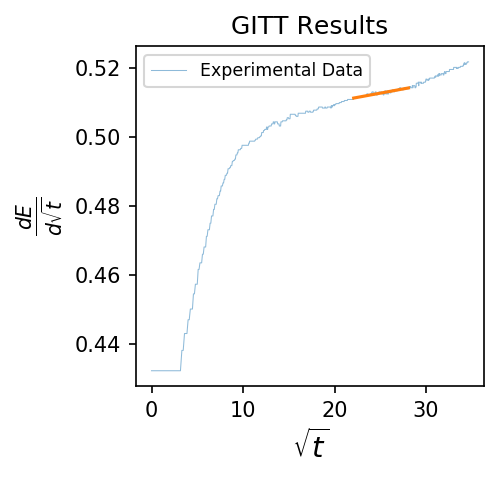

In [161]:
plot_results(data)